# Intro to Argovis' Grid API

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll illustrate some basic operations and handling of this data.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [115]:
import requests, xarray, pandas, math, datetime
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import hvplot.xarray

API_KEY=''

## Downloading Gridded Data

Argovis offers gridded data at its `/grids` endpoint. Available query string parameters are:

 - `gridName` (mandatory, one of rgTempTotal, rgPsalTotal, ohc): name of gridded product to search.
 - `startDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (mandatory, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `presRange` (optional, format minimum_pressure,maximum_pressure): pressure window to filter for.

As noted, `gridName`, `startDate`, `endDate` and `polygon` are all required for downloading gridded data, but we can get just the metadata record that describes some high-level information about each grid by providing only the `gridName` parameter:


In [2]:
params = {
  "gridName": 'psalTotal',
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
print(r.json())

{'code': 404, 'message': 'Not found: No matching results found in database.'}


We see information about the Roemmich-Gilson Argo climatology, like what pressure levels are present, what the minimum and maximum of latitude, longitude and time is in the grid, and soforth.

Let's try a simple request to download a piece of data from this climatology, a 10 degree box over the North Atlantic from the first quarter of 2012:

In [49]:
params = {
  "gridName": 'rgTempTotal',
  "startDate": '2004-01-01T00:00:00Z',
  "endDate": '2018-01-01T00:00:00Z',
#   "polygon": '[[-55.621094,42.163403],[-71.367188,40.580585],[-74.003906,37.439974],[-75.058594,35.029996],[-79.453125,32.249974],[-80.15625,29.993002],[-78.75,23.725012],[-73.828125,21.289374],[-70.3125,20.797201],[-67.5,19.47695],[-64.160156,19.47695],[-55.621094,42.163403]]'
  "polygon": '[[-170,30],[-170,60],[-120,60],[-120,30],[-170,30]]'
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
rgdata = r.json()

In [5]:
# 23.885838,-171.210938%5D,%5B59.085739,-169.628906%5D,%5B60.135248,-160.953686%5D,%5B60.586967,-151.875%5D,%5B60.569395,-144.531179%5D,%5B60.152442,-137.285156%5D,%5B51.727028,-127.265625%5D,%5B44.21371,-120.058594%5D,%5B23.563987,-110.390625%5D,%5B14.944785,-109.511719%5D,%5B15.828692,-117.106105%5D,%5B16.446697,-124.756976%5D,%5B16.786136,-132.445571%5D,%5B16.839929,-140.150052%5D,%5B16.606949,-147.847265%5D,%5B16.092071,-155.514661%5D,%5B15.305928,-163.132141%5D,%5B14.264383,-170.683594%5D,%5B23.885838,-171.210938

(If you need help constructing a polygon, try the following:

  - visit argovis.colorado.edu
  - draw a shape
  - click on the purple shaded area of the region of interest (not on a dot)
  - from the pop up window, go "to Selection page"
  - from the url of the selection shape, copy the shape, i.e. [copy_all_this_inside_outer_brackets] after 'shape=')


Like most Argovis API requests, you get a list of documents matching your query. Let's have a look at the first record in what the API returned to us:

The first object in a request to `/grids` is always the appropriate *metadata record* for the grid, the same as what you got from `/grids?gridName=rgTempTotal` above. We automatically include it at the front of the full data requests as it is necessary for interpreting that data, as we'll see immediately below.

All the records returned by `/grids` after the first specify the actual data we wanted; let's have a look at one of them:

In [50]:
rgdata[1]

{'_id': '6264c4f3aa7c8506073604b0',
 'g': {'type': 'Point', 'coordinates': [-134.5, 34.5]},
 't': '2017-12-15T00:00:00.000Z',
 'd': [18.234001,
  18.237999,
  18.247,
  18.24,
  18.272001,
  18.336,
  18.377001,
  17.995998,
  16.945999,
  16.342001,
  15.563,
  14.652,
  13.913,
  13.507,
  13.187,
  12.899,
  12.445,
  12.125,
  11.746,
  11.179,
  10.649,
  10.35,
  10.009,
  9.588,
  9.158999,
  8.771999,
  8.412,
  8.035,
  7.67,
  7.362,
  7.079,
  6.798,
  6.512,
  6.093,
  5.658,
  5.339,
  5.059,
  4.802,
  4.604,
  4.423,
  4.259,
  4.112,
  3.965,
  3.819,
  3.678,
  3.548,
  3.425,
  3.313,
  3.213,
  3.116,
  3.025,
  2.906,
  2.748,
  2.566,
  2.404,
  2.262,
  2.14,
  2.057]}

By default, Argovis returns gridded data in a *profile-like* structure: this record, located in space by its `g` key (for geolocation) and time by its `t` key, contains the grid points for all corresponding depths in its `d` (for data) key. To interpret the list of numbers, compare it entry-by-entry to the `levels` key in the metadata record; for example, the two records printed above indicate that the temperature at these coordinates and 10 dbar depth is 25.118999.

## Ingestion by xarray

Xarray is a familiar pythonic data structure; we can transform a raw API response to an xarray with a helper similar to the following.

In [51]:
def xargrid(grid):
    # given the json response <grid> of a request to /grids,
    # return an xarray object with coordinates time, lat, lon, depth, and measurement value.
    
    lat = []
    lon = []
    time = []
    pres = []
    meas = []
    for p in grid[1:]:
        for i, e in enumerate(p['d']):
            lon.append(p['g']['coordinates'][0])
            lat.append(p['g']['coordinates'][1])
            # convert a string to a date (zeros to check at the end of date)
            time.append(datetime.strptime(p['t'], '%Y-%m-%dT%H:%M:%S.%fZ'))
            meas.append(p['d'][i])
            pres.append(grid[0]['levels'][i])
            
    df = pandas.DataFrame({"latitude": lat, 
                           "longitude": lon, 
                           "time": time, 
                           "pressure": pres, 
                           "measurement": meas}).set_index(["latitude","longitude","time","pressure"])
    return df.to_xarray()
    
ds = xargrid(rgdata)

Now we can do all the usual xarray operations; lets see what the ranges of our coordinate variables are:

In [52]:
print('latitudes:',ds['latitude'].data)
print('longitudes:',ds['longitude'].data)
# print('times:',ds['time'].data)
print('pressures:',ds['pressure'].data)

latitudes: [30.5 31.5 32.5 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5 41.5 42.5 43.5
 44.5 45.5 46.5 47.5 48.5 49.5 50.5 51.5 52.5 53.5 54.5 55.5 56.5 57.5
 58.5 59.5]
longitudes: [-169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5
 -159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 -139.5 -138.5 -137.5 -136.5 -135.5 -134.5 -133.5 -132.5 -131.5 -130.5
 -129.5 -128.5 -127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5]
pressures: [   2.5   10.    20.    30.    40.    50.    60.    70.    80.    90.
  100.   110.   120.   130.   140.   150.   160.   170.   182.5  200.
  220.   240.   260.   280.   300.   320.   340.   360.   380.   400.
  420.   440.   462.5  500.   550.   600.   650.   700.   750.   800.
  850.   900.   950.  1000.  1050.  1100.  1150.  1200.  1250.  1300.
 1350.  1412.5 1500.  1600.  1700.  1800.  1900.  1975. ]


We can easily select a slice of this array at constant pressure and time, to produce a possibly more conventional, map-like grid representation, and plot it with xarray's built in plots:

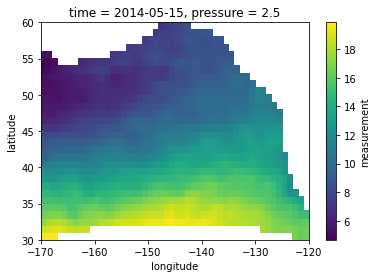

In [53]:
gridmap = ds.loc[{"time":'2014-05-15T00:00:00.000Z', "pressure":2.5}]
gridmap['measurement'].plot()

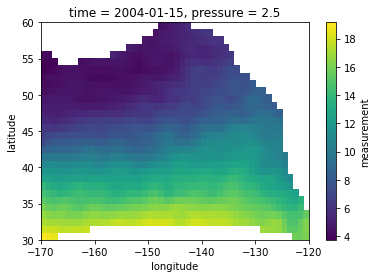

In [54]:
ds.measurement.isel(time=0,pressure=0).plot()

In [57]:
tmp.measurement.isel(pressure=0).hvplot(groupby='time',cmap='Reds')#,widget_type='scrubber')

:DynamicMap   [time]
   :Image   [longitude,latitude]   (measurement)

In [20]:
ds.measurement.isel(pressure=0).hvplot(
    groupby="time",  # adds a widget for time
    clim=(0, 18),  # sets colormap limits
    cmap="Reds",
    widget_type="scrubber",
    widget_location="bottom",
    coastline=True
)


Column
    [0] HoloViews(DynamicMap, widget_location='bottom', widget_type='scrubber')
    [1] Row
        [0] HSpacer()
        [1] WidgetBox
            [0] Player(end=167, width=550)
        [2] HSpacer()

# Calculate anomaly

In [58]:
ds_seas_anom = ds.measurement.groupby('time.month') - ds.measurement.groupby('time.month').mean()

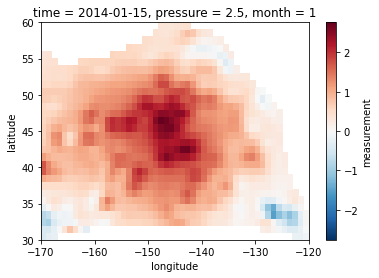

In [87]:
ds_seas_anom.isel(pressure=0).sel(time=('2014-01')).plot()

In [108]:
import matplotlib.pyplot as plt

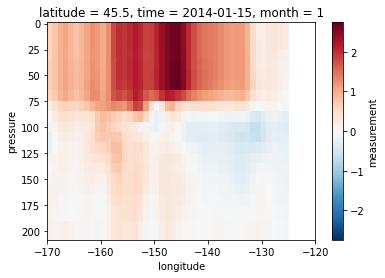

In [112]:
ds_seas_anom.isel(pressure=slice(0,20)).sel(time=('2014-01')).sel(latitude=45.5).squeeze().transpose().plot()
plt.gca().invert_yaxis()

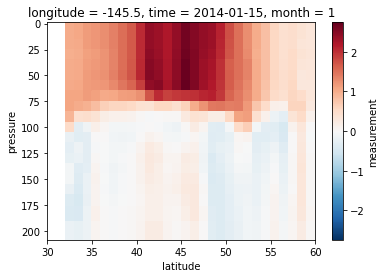

In [114]:
ds_seas_anom.isel(pressure=slice(0,20)).sel(time=('2014-01')).sel(longitude=-145.5).squeeze().transpose().plot()
plt.gca().invert_yaxis()

## Area-Weighted Means over a longitude/latitude region

A common operation when considering gridded data is to weight a mean by area of grid cells, which changes with latitude. A helper to do this with Argovis grid data could look like the following.

In [42]:
def areaweighted_region_mean(dxr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    weights = np.cos(np.deg2rad(dxr.latitude))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean(("longitude", "latitude"))

In [80]:
dxr_aw = areaweighted_region_mean(dxr=ds_seas_anom)
print(dxr_aw.loc[{"time":'2012-01-15T00:00:00.000Z', "pressure":2.5}])
dxr_aw

<xarray.DataArray ()>
array(0.03450476)
Coordinates:
    time      datetime64[ns] 2012-01-15
    pressure  float64 2.5
    month     int64 1


<xarray.DataArray (time: 168, pressure: 58)>
array([[-0.25269628, -0.25353336, -0.25304721, ..., -0.00869916,
        -0.00783859, -0.00263677],
       [-0.13952451, -0.13814973, -0.13437997, ..., -0.01131961,
        -0.00922777, -0.00196394],
       [-0.01302429, -0.01140964, -0.01192249, ..., -0.00594303,
        -0.00368779,  0.00356024],
       ...,
       [-0.00090703, -0.00095366,  0.0045233 , ...,  0.00437909,
         0.00488716,  0.00372253],
       [ 0.28267831,  0.28215723,  0.28063224, ...,  0.00720482,
         0.00712291,  0.00577569],
       [ 0.02414477,  0.02340016,  0.0231874 , ...,  0.00520984,
         0.00643263,  0.00445281]])
Coordinates:
  * time      (time) datetime64[ns] 2004-01-15 2004-02-15 ... 2017-12-15
  * pressure  (pressure) float64 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

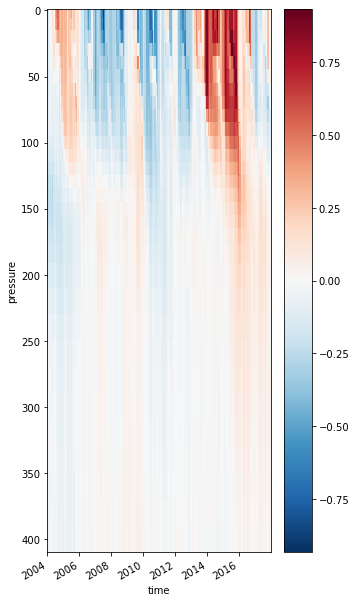

In [116]:
# Let's print the data after the spatial average over longitude and latitude
dxr_aw.isel(pressure=slice(0,30)).plot(y="pressure",yincrease=False,aspect=0.5, size=10)